# Trajectory Regularization - SOM

In [33]:
import minisom as ms
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import clustering as clr

PATH = ''
CODE = '4_040'

In [34]:
# load the pickle file
with open(PATH+'means_vars'+CODE+'.p', 'rb') as infile:
    means_true, vars_true = pickle.load(infile)

In [36]:
n_frame = means_true.shape[0]
time = np.arange(n_frame).T.reshape((n_frame,1))
data = np.concatenate((time, means_true[:,0:2]), axis=1)

## SOM on denoised means series

In [49]:
pred = clr.dbscan(data, eps=20, min_samples=10)
clr.dbscan_info(pred)

Estimated number of clusters: 1
Estimated number of noise points: 0


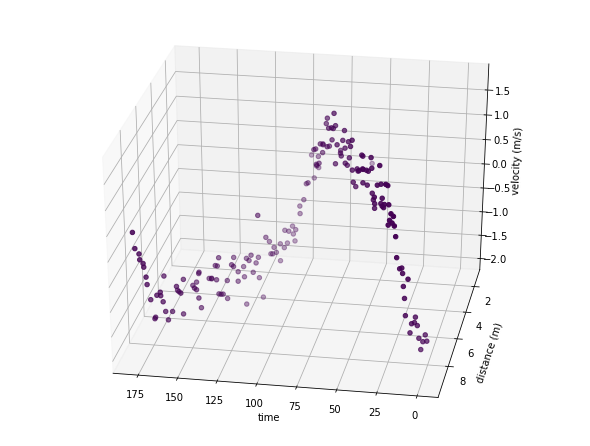

In [57]:
fig = plt.figure(figsize=(8,6))
ax = Axes3D(fig)

ax.scatter(data[:,0], data[:,1], data[:,2], c=pred.labels_, marker='o')

ax.set_xlabel('time')
ax.set_ylabel('distance (m)')
ax.set_zlabel('velocity (m/s)')

ax.view_init(azim=100)

plt.show()

SOM is performed on cleaned data

In [51]:
data_dbscan = data[pred.labels_ != -1]

som_dbscan = ms.MiniSom(1, 15, 3, sigma=0.1, learning_rate=0.7)
som_dbscan.random_weights_init(data_dbscan)
som_dbscan.train_random(data_dbscan, 50000) # trains the SOM with 10000 iterations

points_dbscan = som_dbscan.get_weights()[0].copy()
points_dbscan = points_dbscan[points_dbscan[:,0].argsort()]

In [52]:
from scipy.interpolate import CubicSpline

pts = np.concatenate((data_dbscan[0,:].T.reshape(1,3), points_dbscan, data_dbscan[-1,:].T.reshape(1,3)))
f_dbscan = CubicSpline(pts[:,0], pts[:,1:])

# calculate new x's and y's
x_new_dbscan = np.linspace(pts[0,0], pts[-1,0], 200)
y_new_dbscan = f_dbscan(x_new_dbscan)

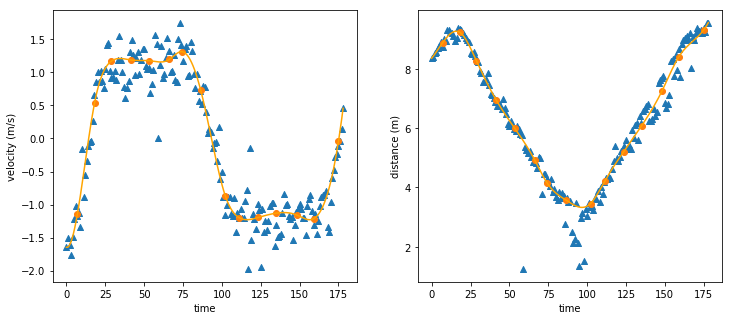

In [54]:
fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(121)
plt.ylabel('velocity (m/s)')
plt.xlabel('time')
ax.scatter(data_dbscan[:,0], data_dbscan[:,2], marker="^")
ax.scatter(points_dbscan[:,0], points_dbscan[:,2], marker='o')
ax.plot(x_new_dbscan, y_new_dbscan[:,1], color='orange')

ax = fig.add_subplot(122)
plt.ylabel('distance (m)')
plt.xlabel('time')
ax.scatter(data_dbscan[:,0], data_dbscan[:,1], marker="^")
ax.scatter(points_dbscan[:,0], points_dbscan[:,1], marker='o')
ax.plot(x_new_dbscan, y_new_dbscan[:,0], color='orange')

plt.show()

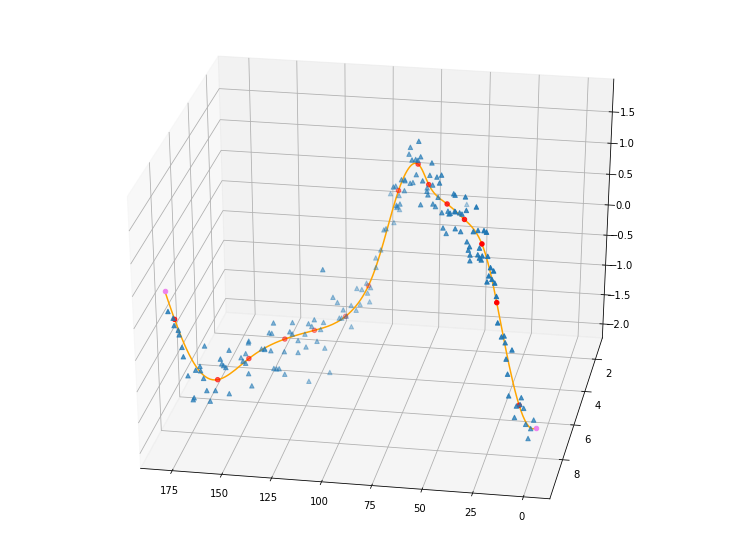

In [55]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot(111, projection='3d')
    
# plots all the points except for the first and the last one
ax.scatter(data_dbscan[1:-1,0], data_dbscan[1:-1,1], data_dbscan[1:-1,2], marker="^")
# plots the neuron of the SOM
ax.scatter(points_dbscan[:,0], points_dbscan[:,1], points_dbscan[:,2], marker='o', color='red')
# plots first and last point in yellow
ax.scatter(data_dbscan[0,0], data_dbscan[0,1], data_dbscan[0,2], marker='o', color='violet', )
ax.scatter(data_dbscan[-1,0], data_dbscan[-1,1], data_dbscan[-1,2], marker='o', color='violet')
# plots the spline
ax.plot3D(x_new_dbscan, y_new_dbscan[:,0], y_new_dbscan[:,1], color='orange')

#plt.axis('off')
ax.view_init(azim=100)
plt.show()
#plt.savefig('GIF/SOM/{}.png'.format(azim))

In [20]:
#import imageio

#images = []
#filenames = ['{}.png'.format(ind) for ind in range(0, 360, 3)]

#for filename in filenames:
#    images.append(imageio.imread('GIF/SOM/'+filename))
    
#imageio.mimsave('thenks_for_attention.gif', images)

In [21]:
with open(PATH+'som_means'+CODE+'.p', 'wb') as outfile:
    pickle.dump(f_dbscan(list(range(n_frame))), outfile)

## SOM for variances
### On DBSCAN-denoised data

In [64]:
pred_var = clr.dbscan(cov_m, eps=8, min_samples=5)
clr.dbscan_info(pred_var)

Estimated number of clusters: 1
Estimated number of noise points: 0


In [65]:
var_m_dbscan = cov_m[pred_var.labels_ != -1]

som_var_dbscan = ms.MiniSom(1, 15, 3, sigma=0.5, learning_rate=0.5)
som_var_dbscan.random_weights_init(var_m_dbscan)
som_var_dbscan.train_random(var_m_dbscan, 10000) # trains the SOM with 10000 iterations

points_var_dbscan = som_var_dbscan.get_weights()[0].copy()
points_var_dbscan = points_var_dbscan[points_var_dbscan[:,0].argsort()]

In [66]:
from scipy.interpolate import CubicSpline

pts = np.concatenate((var_m_dbscan[0,:].T.reshape(1,3), 
                      points_var_dbscan, 
                      var_m_dbscan[-1,:].T.reshape(1,3)))

f_var_dbscan = CubicSpline(pts[:,0], pts[:,1:])

# calculate new x's and y's
x_var_new_dbscan = np.linspace(pts[0,0], pts[-1,0], 200)
y_var_new_dbscan = f_var_dbscan(x_var_new_dbscan)

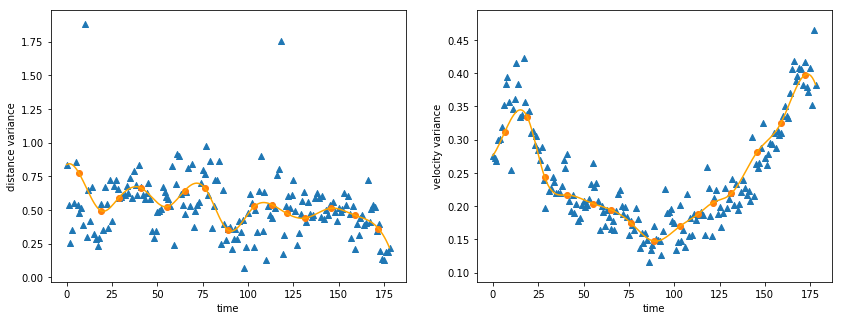

In [67]:
dim = (380, 256)
fig = plt.figure(figsize=(14,5))

ind = 1
ax = fig.add_subplot(121)
plt.ylabel('distance variance')
plt.xlabel('time')
#plt.ylim((0, 4000))
ax.scatter(cov_m[:,0], cov_m[:,ind], marker="^")
ax.scatter(points_var_dbscan[:,0], points_var_dbscan[:,ind], marker='o')
ax.plot(x_var_new_dbscan, y_var_new_dbscan[:,ind-1], color='orange')

ind = 2
ax = fig.add_subplot(122)
plt.ylabel('velocity variance')
plt.xlabel('time')
#plt.ylim((0, 4000))
ax.scatter(cov_m[:,0], cov_m[:,ind], marker="^")
ax.scatter(points_var_dbscan[:,0], points_var_dbscan[:,ind], marker='o')
ax.plot(x_var_new_dbscan, y_var_new_dbscan[:,ind-1], color='orange')

plt.show()

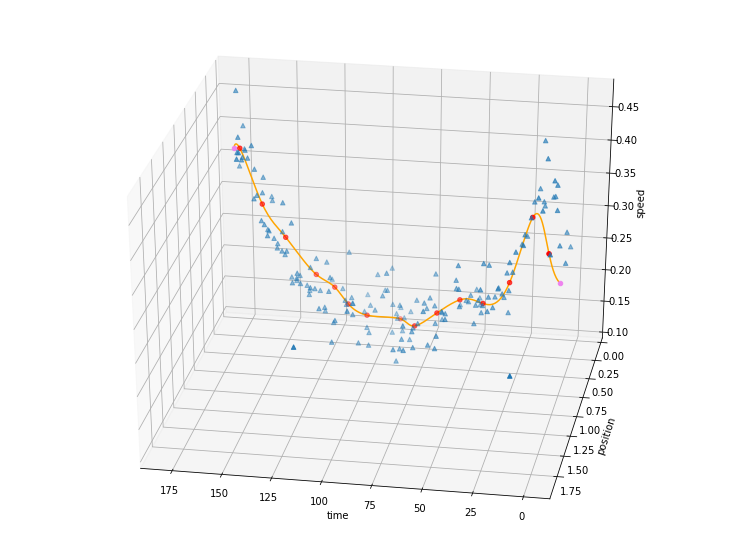

In [68]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot(111, projection='3d')

# plots all the points except for the first and the last one
ax.scatter(cov_m[1:-1,0], cov_m[1:-1,1], cov_m[1:-1,2], marker="^")
# plots the neuron of the SOM
ax.scatter(points_var_dbscan[:,0], points_var_dbscan[:,1], points_var_dbscan[:,2], marker='o', color='red')
# plots first and last point in yellow
ax.scatter(cov_m[0,0], cov_m[0,1], cov_m[0,2], marker='o', color='violet')
ax.scatter(cov_m[-1,0], cov_m[-1,1], cov_m[-1,2], marker='o', color='violet')
# plots the spline
ax.plot3D(x_var_new_dbscan, y_var_new_dbscan[:,0], y_var_new_dbscan[:,1], color='orange')

ax.set_xlabel('time')
ax.set_ylabel('position')
ax.set_zlabel('speed')
ax.view_init(azim=100)

plt.show()

In [34]:
with open(PATH+'som_vars'+CODE+'.p', 'wb') as outfile:
    pickle.dump(f_var_dbscan(list(range(n_frame))), outfile)

## Final plot

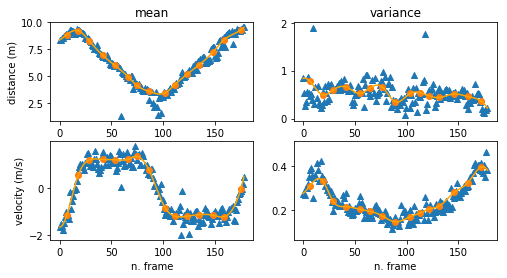

In [70]:
fig = plt.figure(figsize=(8,4))

ind = 1
ax = fig.add_subplot(222)
plt.title('variance')
ax.scatter(cov_m[:,0], cov_m[:,ind], marker="^")
ax.scatter(points_var_dbscan[:,0], points_var_dbscan[:,ind], marker='o')
ax.plot(x_var_new_dbscan, y_var_new_dbscan[:,ind-1], color='orange')

ind = 2
ax = fig.add_subplot(224)
plt.xlabel('n. frame')
ax.scatter(cov_m[:,0], cov_m[:,ind], marker="^")
ax.scatter(points_var_dbscan[:,0], points_var_dbscan[:,ind], marker='o')
ax.plot(x_var_new_dbscan, y_var_new_dbscan[:,ind-1], color='orange')

ax = fig.add_subplot(223)
plt.ylabel('velocity (m/s)')
plt.xlabel('n. frame')
ax.scatter(data[:,0], data[:,2], marker="^")
ax.scatter(points_dbscan[:,0], points_dbscan[:,2], marker='o')
ax.plot(x_new_dbscan, y_new_dbscan[:,1], color='orange')

ax = fig.add_subplot(221)
plt.ylabel('distance (m)')
plt.title('mean')
ax.scatter(data[:,0], data[:,1], marker="^")
ax.scatter(points_dbscan[:,0], points_dbscan[:,1], marker='o')
ax.plot(x_new_dbscan, y_new_dbscan[:,0], color='orange')

plt.savefig('som_riassunto.png')

plt.show()